# Analyzing Reddit’s Climate Change Discourse: A Distributed Study of Topic Modeling and Sentiment Analysis Techniques

### Candidate numbers: 39884, 48099, 49308, 50250

## Notebook Overview

- **Preprocessing:** load and clean Reddit comments, tokenize and filter.  
- **Topic Modeling:** apply LDA (Spark MLlib) and NMF (scikit-learn TF-IDF), extract dominant topics.  
- **Evaluation:** measure coherence (C_V, UMass, NPMI) etc.  
- **Topic Evolution Over Time:** chart LDA topic proportions by period.  

### Installs and libraries

In [ ]:
#!pip install gensim
import zipfile
import os
import re
import hashlib
from datetime import datetime
import numpy as np
import pandas as pd
import string
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from pyspark.sql import SparkSession
import pyspark.sql.functions as sql_f 
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.clustering import LDA
from time import time
from pyspark.sql.functions import udf, col, rand, monotonically_increasing_id
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, ArrayType
from pyspark.ml.feature import StopWordsRemover, Tokenizer, CountVectorizer, IDF
from pyspark.sql.functions import lower, regexp_replace, row_number, desc
import random
from pyspark.sql.functions import rand
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from pyspark.sql.functions import year
from pyspark.sql.window import Window
import matplotlib.pyplot as plt

# Data Preprocessing and Cleaning

- Downloaded the Reddit Climate Change dataset from Kaggle as a ZIP file using the Kaggle API.
- Unzipped the archive to extract the comments CSV file.
- Uploaded the `the-reddit-climate-change-dataset-comments.csv` file to HDFS, replacing any previous version.
- Verified the successful upload by listing the contents of the HDFS root directory.

In [3]:
# Download the Kaggle dataset zip
!curl -L -o climate.zip \
    "https://www.kaggle.com/api/v1/datasets/download/pavellexyr/the-reddit-climate-change-dataset"

# Unzip it (this will extract all files, including the comments CSV)
!unzip -o climate.zip

# Remove any old copy in HDFS and put the comments file there
!hadoop fs -rm -f /the-reddit-climate-change-dataset-comments.csv
!hadoop fs -put the-reddit-climate-change-dataset-comments.csv /

# Verify upload
!hadoop fs -ls /

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1536M  100 1536M    0     0  41.1M      0  0:00:37  0:00:37 --:--:-- 42.7M 0:00:39  0:00:12  0:00:27 42.8M
Archive:  climate.zip
  inflating: the-reddit-climate-change-dataset-comments.csv  
  inflating: the-reddit-climate-change-dataset-posts.csv  
Found 4 items
-rw-r--r--   2 root hadoop 4111000325 2025-05-05 14:08 /the-reddit-climate-change-dataset-comments.csv
drwxrwxrwt   - hdfs hadoop          0 2025-05-05 14:00 /tmp
drwxrwxrwt   - hdfs hadoop          0 2025-05-05 14:05 /user
drwxrwxrwt   - hdfs hadoop          0 2025-05-05 13:58 /var


In [ ]:
# Point to the HDFS path
comments_path = "hdfs://st446-cluster-w10-m:8020/the-reddit-climate-change-dataset-comments.csv"

### Load Dataset into Spark

Below, we define a custom schema to properly parse the Reddit comments CSV file. This ensures correct data types and handles multiline fields. We then load the dataset into a Spark DataFrame using this schema, and display the schema and a preview of the first five rows to verify successful loading.

In [5]:
# Define the schema for the comments file

schema = StructType([
    StructField("type",           StringType(), True),
    StructField("id",             StringType(), True),
    StructField("subreddit.id",   StringType(), True),
    StructField("subreddit.name", StringType(), True),
    StructField("subreddit.nsfw", StringType(), True),
    StructField("created_utc",    StringType(), True),
    StructField("permalink",      StringType(), True),
    StructField("body",           StringType(), True),
    StructField("sentiment",      DoubleType(), True),
    StructField("score",          IntegerType(),True)
])

df = spark.read \
    .option("header", "true") \
    .option("multiLine", "true") \
    .option("escape", "\"") \
    .schema(schema) \
    .csv(comments_path)

df.printSchema()
df.show(5)

root
 |-- type: string (nullable = true)
 |-- id: string (nullable = true)
 |-- subreddit.id: string (nullable = true)
 |-- subreddit.name: string (nullable = true)
 |-- subreddit.nsfw: string (nullable = true)
 |-- created_utc: string (nullable = true)
 |-- permalink: string (nullable = true)
 |-- body: string (nullable = true)
 |-- sentiment: double (nullable = true)
 |-- score: integer (nullable = true)



+-------+-------+------------+--------------+--------------+-----------+--------------------+--------------------+---------+-----+
|   type|     id|subreddit.id|subreddit.name|subreddit.nsfw|created_utc|           permalink|                body|sentiment|score|
+-------+-------+------------+--------------+--------------+-----------+--------------------+--------------------+---------+-----+
|comment|imlddn9|       2qh3l|          news|         false| 1661990368|https://old.reddi...|Yeah but what the...|   0.5719|    2|
|comment|imldbeh|       2qn7b|          ohio|         false| 1661990340|https://old.reddi...|Any comparison of...|  -0.9877|    2|
|comment|imldado|       2qhma|    newzealand|         false| 1661990327|https://old.reddi...|I'm honestly wait...|  -0.1143|    1|
|comment|imld6cb|       2qi09|    sacramento|         false| 1661990278|https://old.reddi...|Not just Sacramen...|      0.0|    4|
|comment|imld0kj|       2qh1i|     askreddit|         false| 1661990206|https://old

### Custom Stopwords List

We created a comprehensive custom stopwords list to remove domain-specific noise and irrelevant tokens from the Reddit comments. This list includes common HTML and LaTeX markup, URL fragments, mathematical symbols, generic formatting terms, and uninformative words often found in web-scraped or user-generated content. Including this alongside standard stopwords helps improve the quality of downstream topic modeling.

In [6]:
custom_stopwords = set([
    "lt", "gt", "ref", "quot", "cite", "br", "amp", "https", "http", "urlhttps", "urlhttp", 
    "file", "image", "jpg", "png", "gif", "svg", "thumb", "px", "category", "url", "external", 
    "link", "source", "web", "cite", "reference", "reflist", "main", "article", "seealso", 
    "further", "infobox", "template", "navbox", "redirect", "harvnb", "isbn", "doi", "pmid", 
    "ssrn", "jstor", "bibcode", "arxiv", "ol", "hdl", "wikidata", "wiki", "math", "sup", "sub", 
    "nbsp", "equation", "displaystyle", "begin", "end", "left", "right", "sqrt", "frac", "sum", 
    "prod", "int", "lim", "rightarrow", "infty", "alpha", "beta", "gamma", "delta", "epsilon", 
    "zeta", "eta", "theta", "iota", "kappa", "lambda", "mu", "nu", "xi", "omicron", "pi", "rho", 
    "sigma", "tau", "upsilon", "phi", "chi", "psi", "omega", "mathrm", "mathbb", "mathcal", 
    "mathbf", "cdots", "ldots", "vdots", "ddots", "forall", "exists", "in", "ni", "subset", 
    "subseteq", "supset", "supseteq", "emptyset", "cap", "cup", "setminus", "not", "times", 
    "div", "cdot", "pm", "mp", "oplus", "otimes", "odot", "leq", "geq", "neq", "approx", 
    "aligncenter", "fontsize", "alignright", "alignleft", "textalign", "bold", "italic", 
    "underline", "strikethrough", "lineheight", "padding", "margin", "width", "height", "float", 
    "clear", "border", "background", "color", "font", "family", "size", "weight", "style", 
    "decoration", "verticalalign", "textindent", "pre-wrap", "nowrap", "valign", "bgcolor", 
    "style", "class", "id", "width", "height", "align", "border", "cellpadding", "cellspacing", 
    "colspan", "rowspan", "nowrap", "target", "rel", "hreflang", "title", "alt", "src", "dir", 
    "lang", "type", "name", "value", "readonly", "multiple", "onclick", "onmousedown", 
    "onmouseup", "onmouseover", "onmouseout", "onload", "onunload", "onsubmit", "onreset", 
    "onfocus", "onblur", "onkeydown", "onkeyup", "onkeypress", "onerror", "infobox", "caption", 
    "cite", "dmy", "mdy", "date", "archive", "www", "com", "org", "access", "ndash", "sfn", "dts", "vauthors", 
    "mvar", "ipaslink", "ipa", "iii", "ibn", "first", "last", "also", "html", "use", "publisher", "year", "one", 
    "page", "new", "trek", "ipablink", "similar", "usual", "two", "abbr", "used", "est", "ibm", "first1",
    "first2", "last1", "last2", "pdf", "der", "ted", "get", "even", "isn", "going", "like", "people", "even",
    "still", "doesn", "much", "make", "many", "made", "don", "did"
])

### Preprocessing and Tokenization

- Sampled 20% of the original Reddit comments (921500 comments) for faster processing.
- Performed basic text cleaning: converted text to lowercase, removed URLs, non-alphabetic characters, and extra whitespace.
- Tokenized the cleaned text into individual words.
- Removed both default English stopwords and our custom stopwords to eliminate uninformative tokens.
- Filtered out very short tokens (≤2 characters) to further reduce noise and keep meaningful words only.

In [7]:
# Draw a 2% sample of the raw comments
sample_df = df.sample(withReplacement=False, fraction=0.20, seed=42)
print(f"Sample size: {sample_df.count()} comments")

# Clean text on the sample
df_clean = (
    sample_df
      .withColumn("body_clean", lower(col("body")))
      .withColumn("body_clean", regexp_replace("body_clean", r"http\S+", ""))  
      .withColumn("body_clean", regexp_replace("body_clean", r"[^a-z\s]", " "))  
      .withColumn("body_clean", regexp_replace("body_clean", r"\s+", " "))     
)

# Tokenize
tokenizer = Tokenizer(inputCol="body_clean", outputCol="tokens")
df_tokens = tokenizer.transform(df_clean)

# Remove stop‐words
default_stops = StopWordsRemover.loadDefaultStopWords("english")
combined_stops = list(set(default_stops) | custom_stopwords)

remover = StopWordsRemover(
    inputCol="tokens",
    outputCol="filtered",
    stopWords=combined_stops
)
df_no_stop = remover.transform(df_tokens)

# Filter out very short tokens
min_len = udf(lambda toks: [t for t in toks if len(t) > 2], ArrayType(StringType()))
df_final = df_no_stop.withColumn("final_tokens", min_len(col("filtered")))

# Inspect
df_final.select("body_clean", "final_tokens").show(5)

Sample size: 921500 comments


+--------------------+--------------------+
|          body_clean|        final_tokens|
+--------------------+--------------------+
|they need to chan...|[need, change, la...|
| gt not climate c...|[climate, change,...|
|you have no real ...|[real, solution, ...|
|correct climate c...|[correct, climate...|
|student loan reli...|[student, loan, r...|
+--------------------+--------------------+
only showing top 5 rows



### Count Vectorization

Applied `CountVectorizer` to convert the cleaned and tokenized text into a sparse vector representation. This step transforms the text into numerical features based on token frequency:

- `minDF=50`: Ignores rare terms that appear in fewer than 50 documents.
- `maxDF=0.8`: Excludes very common terms that appear in more than 80% of documents.

The result is stored in the `rawFeatures` column and will be used as input for topic modeling.

In [ ]:
cv = CountVectorizer(
    inputCol="final_tokens",
    outputCol="rawFeatures",
    minDF=50,
    maxDF=0.8
)
cv_model = cv.fit(df_final)
df_tf = cv_model.transform(df_final)

In [11]:
df_tf.select("final_tokens", "rawFeatures").show(5)

vocab_sample = cv_model.vocabulary
print(f"Sample vocab size: {len(vocab_sample)}")
print("First 20 sample-vocab entries:", vocab_sample[:20])


[Stage 10:>                                                         (0 + 1) / 1]



+--------------------+--------------------+
|        final_tokens|         rawFeatures|
+--------------------+--------------------+
|[need, change, la...|(26919,[6,53,93,1...|
|[climate, change,...|(26919,[2,15,33,6...|
|[real, solution, ...|(26919,[1,13,14,1...|
|[correct, climate...|(26919,[0,24,290,...|
|[student, loan, r...|(26919,[36,108,21...|
+--------------------+--------------------+
only showing top 5 rows

Sample vocab size: 26919
First 20 sample-vocab entries: ['think', 'world', 'years', 'time', 'know', 'way', 'need', 'want', 'things', 'really', 'global', 'see', 'say', 'good', 'well', 'science', 'believe', 'point', 'trump', 'actually']


Displayed a sample of the final tokenized documents along with their corresponding sparse vector representations (`rawFeatures`). This confirms that the vectorization process successfully mapped words to numerical features.

- Total vocabulary size: **26,919** unique terms met the `minDF` and `maxDF` thresholds.
- A preview of the first 20 vocabulary terms reveals that common climate-related and conversational terms (e.g., *think*, *global*, *science*, *trump*) are well-represented.

# Topic Modelling

# 1. Latent Dirichlet Allocation (LDA)

Configured and trained a Latent Dirichlet Allocation model with the following parameters:
- **k = 10** topics
- **maxIter = 20** iterations
- **featuresCol = "rawFeatures"**, using the term-frequency vectors as input

The model was trained on the sampled and preprocessed Reddit comments to uncover hidden thematic structures (topics) in the climate discourse.

In [9]:
k = 10
max_iters = 20

lda = LDA(
    k=k,
    maxIter=max_iters,
    featuresCol="rawFeatures",
    seed=123,          
)

# Fit on sampled vectorized data
lda_model = lda.fit(df_tf)

### Extracting and Displaying LDA Topics

After training the LDA model, we retrieved and examined the top 10 terms for each of the 10 discovered topics:
- Used `describeTopics()` to get the most important words and their weights per topic.
- Mapped term indices back to actual words using the vocabulary from the `CountVectorizer`.
- Printed a readable summary of each topic’s key terms and their corresponding weights.

This step helps in interpreting and labeling each latent topic based on its most representative words.

In [20]:
# Describe the top 6 terms for each of the k=10 topics
topics = lda_model.describeTopics(10)
topics.show(truncate=False)

# Retrieve vocabulary from the CountVectorizer
vocab = cv_model.vocabulary

# Map each topic to its actual words and weights
topic_words = topics.rdd.map(
    lambda row: (
        row['topic'],
        [vocab[i] for i in row['termIndices']],
        row['termWeights']
    )
).collect()

# Print
print("\nIdentified Topics:")
for topic, words, weights in topic_words:
    print(f"Topic {topic}:")
    for w, wt in zip(words, weights):
        print(f"  {w}: {wt:.4f}")
    print()

+-----+-------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|termIndices                                      |termWeights                                                                                                                                                                                                                      |
+-----+-------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |[10, 2, 23, 29, 1, 65, 18, 16, 88, 0]            |[0.010710459743446523, 0.008315895012499843, 0.007918404308458254, 0.007199850178458712, 0.


Identified Topics:
Topic 0:
  global: 0.0107
  years: 0.0083
  real: 0.0079
  warming: 0.0072
  world: 0.0061
  planet: 0.0051
  trump: 0.0044
  believe: 0.0041
  humans: 0.0039
  think: 0.0036

Topic 1:
  think: 0.0066
  anti: 0.0059
  trump: 0.0057
  political: 0.0050
  party: 0.0049
  want: 0.0048
  believe: 0.0045
  see: 0.0043
  vote: 0.0041
  issues: 0.0039

Topic 2:
  said: 0.0052
  energy: 0.0051
  world: 0.0033
  environmental: 0.0029
  time: 0.0028
  global: 0.0027
  think: 0.0024
  emissions: 0.0024
  work: 0.0021
  government: 0.0021

Topic 3:
  science: 0.0135
  scientists: 0.0078
  scientific: 0.0071
  evidence: 0.0068
  know: 0.0062
  believe: 0.0057
  think: 0.0054
  say: 0.0047
  data: 0.0046
  warming: 0.0042

Topic 4:
  women: 0.0088
  world: 0.0057
  men: 0.0057
  children: 0.0057
  think: 0.0040
  life: 0.0037
  kids: 0.0036
  child: 0.0036
  white: 0.0029
  sex: 0.0029

Topic 5:
  years: 0.0076
  global: 0.0055
  carbon: 0.0054
  energy: 0.0051
  emissions: 0.004


[Stage 115:============================>                            (1 + 1) / 2]



## Identified Topics from LDA (k = 10)

Below are the 10 topics extracted from the LDA model, each summarized with its most representative terms and a short interpretation of the theme:

- **Topic 0 – Global Warming & Reality**  
  *Words:* `global`, `years`, `real`, `warming`, `world`, `planet`, `trump`, `believe`, `humans`, `think`  
  *Description:* Focuses on discussions questioning or affirming the reality of climate change and its long-term planetary impact.

- **Topic 1 – Political Opinions & Division**  
  *Words:* `think`, `anti`, `trump`, `political`, `party`, `want`, `believe`, `see`, `vote`, `issues`  
  *Description:* Captures ideological debates, partisanship, and political conflict surrounding climate-related issues.

- **Topic 2 – Environmental Policy**  
  *Words:* `said`, `energy`, `world`, `environmental`, `time`, `global`, `think`, `emissions`, `work`, `government`  
  *Description:* Centers around government actions, environmental regulation, and public policy in the climate space.

- **Topic 3 – Scientific Discourse**  
  *Words:* `science`, `scientists`, `scientific`, `evidence`, `know`, `believe`, `think`, `say`, `data`, `warming`  
  *Description:* Covers the scientific community’s stance, data discussions, and public perception of climate science.

- **Topic 4 – Gender, Life & Climate**  
  *Words:* `women`, `world`, `men`, `children`, `think`, `life`, `kids`, `child`, `white`, `sex`  
  *Description:* Intersects climate talk with gender, family, and social issues.

- **Topic 5 – Carbon, Energy & Emissions**  
  *Words:* `years`, `global`, `carbon`, `energy`, `emissions`, `warming`, `water`, `time`, `earth`, `world`  
  *Description:* Focuses on technological and scientific aspects of carbon reduction and energy systems.

- **Topic 6 – Veganism & Lifestyle Activism**  
  *Words:* `meat`, `bernie`, `food`, `animal`, `bot`, `animals`, `eat`, `vegan`, `comments`, `water`  
  *Description:* Relates to food choices, plant-based diets, and activism as climate responses.

- **Topic 7 – Economic Policy & Taxation**  
  *Words:* `money`, `government`, `tax`, `think`, `want`, `need`, `world`, `carbon`, `good`, `energy`  
  *Description:* Discusses financial strategies and taxation related to climate funding or policy.

- **Topic 8 – U.S. Political Figures**  
  *Words:* `trump`, `biden`, `party`, `president`, `vote`, `policy`, `bernie`, `obama`, `election`, `years`  
  *Description:* Reflects on the role of key U.S. politicians in shaping or blocking climate agendas.

- **Topic 9 – General Reflections & Concerns**  
  *Words:* `think`, `world`, `way`, `things`, `really`, `know`, `time`, `need`, `something`, `want`  
  *Description:* Captures vague, broad personal opinions, concerns, or abstract reflection on climate and society.

### Document-Level Topic Assignment and Top Words

In this step, each Reddit comment is:
- Assigned a **dominant topic**, based on which topic has the highest probability in the LDA `topicDistribution`.
- Enriched with a list of the **top words** most relevant to its dominant topic.

To compute these document-level topic words, we:
- Use the global word weights for each topic (from `describeTopics(50)`),
- Cross-reference them with the document’s actual word frequencies (from the CountVectorizer output),
- Weight by the document's own probability of belonging to the dominant topic,
- Apply light random noise to avoid ties and add diversity.

This results in a meaningful set of ~10 representative words per document, making it easier to interpret what the model "sees" in each comment.

In [10]:
sc = spark.sparkContext

# Predict dominant topic per document
def dominant_topic(topicDist):
    return int(topicDist.argmax())

dominant_topic_udf = udf(dominant_topic, IntegerType())

df_topics = lda_model.transform(df_tf) \
    .withColumn("predictedTopic", dominant_topic_udf("topicDistribution")) \
    .withColumn("unique_id", monotonically_increasing_id())

# Build full topic→(words,weights) dict from describeTopics(50)
topics50 = lda_model.describeTopics(50)
vocab = cv_model.vocabulary  

topic_full = topics50.rdd.map(lambda row: (
    row['topic'],
    [vocab[i] for i in row['termIndices']],
    row['termWeights']
)).collect()

topic_full_dict = {t: (words, weights) for t, words, weights in topic_full}
topic_full_b = sc.broadcast(topic_full_dict)

# UDF to pick doc-specific top words
def doc_top_words(td, raw, num=10):
    dom = int(td.argmax())
    if dom not in topic_full_b.value:
        return []
    cand_words, cand_wts = topic_full_b.value[dom]

    # build index→count map
    counts = {i: v for i, v in zip(raw.indices, raw.values)} if raw else {}

    dom_prob = float(td[dom])
    scores = {}
    for w, wt in zip(cand_words, cand_wts):
        try:
            idx = vocab.index(w)
            freq = counts.get(idx, 0)
        except ValueError:
            freq = 0
        noise = 1 + 0.05 * random.random()
        scores[w] = freq * wt * dom_prob * noise

    # sort & pick top
    sorted_ = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    if all(s==0 for _, s in sorted_):
        return random.sample(cand_words, min(num, len(cand_words)))
    return [w for w, _ in sorted_[:num]]

doc_top_udf = udf(doc_top_words, ArrayType(StringType()))

# Apply to get docTopWords
df_with_words = df_topics.withColumn(
    "docTopWords",
    doc_top_udf("topicDistribution", "rawFeatures")
)

In [22]:
result = df_with_words.selectExpr(
    "unique_id",
    "body_clean",
    "`subreddit.name` AS subreddit",   
    "predictedTopic",
    "docTopWords"
).orderBy(rand()).limit(15)

result.show()

25/04/24 21:29:44 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


+---------+--------------------+-------------------+--------------+--------------------+
|unique_id|          body_clean|          subreddit|predictedTopic|         docTopWords|
+---------+--------------------+-------------------+--------------+--------------------+
|   349362| gt i dont unders...|          stupidpol|             8|[biden, trump, pr...|
|   385806|are you not aware...|         nottingham|             5|[less, air, years...|
|   551132|truth of climate ...|    murderedbywords|             3|[facts, believe, ...|
|   887431|climate change wh...|             canada|             5|[time, earth, thi...|
|   248164|quick question fo...|       changemyview|             5|[think, see, poin...|
|   375796| gt he is further...|               lgbt|             8|[trump, biden, pa...|
|    96151|was alive for hou...|seenonnews_longtail|             2|[india, work, chi...|
|   381198|not vegetarian bu...|              vegan|             6|[meat, vegan, ani...|
|   224008| gt rare f

We also use `.show(truncate=False)` to print the full, untruncated text of each comment for easier inspection.

In [23]:
result.show(truncate=False)

25/04/24 21:44:18 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


+---------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### LDA Topic Assignment – Commentary with Real Examples

Below we analyze specific examples from the 20% LDA sample to assess how well the model assigned topics to documents. We focus on subreddit–topic alignment and the interpretability of top words.

### Strong Matches Between Content and Topic

- **Topic 8 – U.S. Political Figures**  
  - **Subreddit**: *stupidpol*  
    **Comment**: A detailed comparison of Trump vs. Biden on COVID, climate policies, and political narratives.  
    **Top Words**: `biden`, `trump`, `president`, `obama`, `policies`, `state`  
    ➤ Perfectly aligned. The model captures the political framing and U.S. figure references.

- **Topic 6 – Veganism & Lifestyle Activism**  
  - **Subreddit**: *vegan*  
    **Comment**: A personal story about transitioning to veganism after climate strikes.  
    **Top Words**: `meat`, `vegan`, `animal`, `eating`, `food`  
    ➤ Excellent topic fit. The model isolates food-related climate concerns.

- **Topic 3 – Scientific Discourse**  
  - **Subreddit**: *murderedbywords*  
    **Comment**: A critique of relying on astrophysicists for climate science opinions.  
    **Top Words**: `science`, `deniers`, `research`, `data`, `global`, `issue`  
    ➤ The topic perfectly captures scientific authority debates.

- **Topic 5 – Carbon, Energy & Emissions**  
  - **Subreddit**: *nottingham*  
    **Comment**: A discussion about urban congestion, public transport, and climate-oriented city planning.  
    **Top Words**: `carbon`, `energy`, `emissions`, `warming`, `air`, `global`  
    ➤ Clear focus on energy and emission themes matches the topic.

- **Topic 0 – Global Warming & Reality**  
  - **Subreddit**: *science*, *worldnews*  
    **Comment**: Includes references to freeze events, planetary systems, and climate change realism.  
    **Top Words**: `planet`, `life`, `years`, `die`, `see`  
    ➤ Strong alignment with discussions of real-world climate impacts.


### Observations

- **Model robustness**: Even long or opinion-heavy posts were well categorized (e.g., *changemyview*, *lgbt*), showing that the LDA model effectively isolated dominant topics from noise.
- **Topic quality**: The top words are **interpretable**, **relevant**, and **consistent** with the document themes.
- **Subreddit reflection**: Posts from *vegan*, *murderedbywords*, and *stupidpol* are matched to expected climate-related topics, proving LDA’s usefulness in mapping subreddit culture to climate discourse.

These results demonstrate that LDA not only discovers **distinct thematic clusters**, but also assigns documents in a way that reflects **subreddit identity**, **linguistic content**, and **climate change discourse diversity**.

# 2. Non-negative Matrix Factorization (NMF)

This section implements topic modeling using **NMF** on the same 20% Reddit sample as the LDA model, enabling a direct comparison.

Steps:
1. **Pull Final Tokens to Python**  
   The `final_tokens` column is sampled (20%) and converted into plain text documents by joining tokens into strings. This is required for scikit-learn's vectorizers, which work outside of Spark.

2. **TF-IDF Vectorization**  
   A `TfidfVectorizer` is applied using the same `min_df=50` and `max_df=0.8` as LDA, along with the combined default + custom stopwords. This converts text into a sparse matrix based on term frequency–inverse document frequency.

3. **Fit NMF Model**  
   An `NMF` model with `n_components=10` (i.e., 10 topics) is fit to the TF-IDF matrix.  
   - `init="nndsvda"` gives faster and more stable convergence.
   - `W` (document-topic matrix) and `H` (topic-word matrix) are extracted for interpretation.

In [ ]:
warnings.filterwarnings("ignore", category=UserWarning,
                        message="Your stop_words may be inconsistent.*")

# Pull the final_tokens
sample_frac = 0.20
token_docs = (
    df_final
      .sample(False, sample_frac, seed=123)
      .select("final_tokens")
      .rdd
      .map(lambda r: " ".join(r.final_tokens))
      .collect()
)

# Vectorize those token-only strings
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(
    max_df=0.8,
    min_df=50,
    stop_words=combined_stops  
)
X = tfidf.fit_transform(token_docs)


# Fit NMF
from sklearn.decomposition import NMF

n_topics = 10
nmf = NMF(
    n_components=n_topics,
    init="nndsvda",
    random_state=123,
    max_iter=200
)
W = nmf.fit_transform(X)
H = nmf.components_

### Inspecting NMF Topics

The code below retrieves and displays the **top 10 words** for each of the 10 NMF topics:

- `H` is the topic-word matrix returned by the fitted NMF model.
- For each topic (i.e., each row in `H`), the code:
  - Sorts the words by their importance (highest weight).
  - Extracts the top 10 terms and their corresponding weights.
- `tfidf.get_feature_names_out()` provides the actual vocabulary terms from the vectorizer.


In [10]:
# Inspect the top words in each topic
terms = tfidf.get_feature_names_out()
for topic_idx, topic in enumerate(H):
    top_idxs   = topic.argsort()[:-11:-1]
    top_terms  = [terms[i] for i in top_idxs]
    top_weights= [topic[i] for i in top_idxs]
    print(f"\nTopic #{topic_idx}:")
    for t, w in zip(top_terms, top_weights):
        print(f"  {t:<15} {w:.4f}")


Topic #0:
  world           1.2359
  want            1.2039
  things          1.1858
  really          1.0997
  know            1.0703
  good            1.0623
  way             1.0387
  need            0.9560
  something       0.9541
  see             0.9056

Topic #1:
  bernie          3.5985
  bot             2.3620
  dakota          1.3180
  considers       1.3030
  grounds         1.2854
  pipeline        1.2628
  opposed         1.1799
  security        1.1602
  national        1.0869
  crisis          0.5594

Topic #2:
  global          3.7617
  warming         3.3740
  cooling         0.3224
  temperature     0.2370
  term            0.2088
  called          0.1956
  weather         0.1666
  temperatures    0.1442
  cold            0.1337
  average         0.1276

Topic #3:
  science         4.5786
  scientists      1.7216
  scientific      1.6000
  deniers         1.3671
  evidence        1.2550
  anti            1.0849
  consensus       0.9212
  data            0.8276
  rese

## NMF Topic Labels (k=10)

After fitting an NMF model with 10 topics, the following dominant themes were identified:

| Topic | Topic Label | Top Keywords (Examples) |
|:-------:|:------------|:-------------------------|
| 0 | General Reflections & Climate Concern | world, want, things, good, way, need, see |
| 1 | Environmental Activism & Dakota Pipeline | bernie, dakota, pipeline, grounds, security |
| 2 | Global Warming & Cooling Debate | global, warming, cooling, temperature, weather |
| 3 | Scientific Consensus on Climate | science, scientists, evidence, data, research, consensus |
| 4 | Climate Change Reality Denial | real, fake, man, problem, threat |
| 5 | U.S. Politics & Climate Change | trump, biden, party, vote, republicans, democrats |
| 6 | Energy Transition & Emissions | energy, carbon, nuclear, emissions, fossil, fuels |
| 7 | Belief Systems & Skepticism | believe, god, evolution, humans, hoax |
| 8 | Earth's Climate History | years, earth, humans, ice, planet, ago |
| 9 | Personal Opinions & Skepticism | think, agree, hoax, issue, lot, probably |

---

### Overlap in Opinion-Focused NMF Topics

NMF produced several topics that heavily reflect **personal opinions and general reflections**:

- **Topic 0 – General Reflections & Climate Concern**: broad thoughts and concern  
- **Topic 4 – Climate Change Reality Denial**: emotional or dismissive reactions  
- **Topic 7 – Belief Systems & Skepticism**: ideological views, e.g., religion or hoaxes  
- **Topic 9 – Personal Opinions & Skepticism**: vague reactions or loosely structured comments

These topics **overlap semantically**, all capturing subjective commentary. While distinct in tone, they collectively represent **public sentiment** rather than specific domains like science, policy, or activism.

### Document-Level Topic Assignment with NMF

In this section, we associate each Reddit comment with its most dominant NMF topic and extract meaningful keywords per comment:

1. **Assign Unique IDs**: Each comment is tagged with a `unique_id` to allow merging after processing.
2. **Sampling & Vectorization**: A 20% sample is collected into a Pandas DataFrame. We reuse the previously fitted `TfidfVectorizer` and apply it to the sampled comments.
3. **Apply NMF**: The pre-trained NMF model is used to generate the document-topic matrix `W` and topic-word matrix `H`.
4. **Broadcast Topics**: For each topic, we extract the top 50 words and weights. This dictionary is broadcast across Spark workers.
5. **Convert to Spark Format**: We convert the document-topic matrix back into a Spark DataFrame and compute each document's dominant topic.
6. **Top Word UDF**: A custom UDF identifies the most relevant words for each document based on its dominant topic and that topic’s top terms.
7. **Join & Show Results**: We join this back with the full dataset and display a random sample of documents alongside their predicted topic and top NMF keywords.

In [ ]:
# Added unique_id to every document in cleaned DF
df_nmf = df_final.withColumn("unique_id", monotonically_increasing_id())

# Sample 20%, collect into Pandas and run TF-IDF + NMF
sample_frac = 0.20
pdf = (
    df_nmf
      .sample(False, sample_frac, seed=123)
      .select("unique_id", "body_clean")
      .toPandas()
)

# Vectorize pre-tokenized text
docs = pdf["body_clean"].tolist()
X = tfidf.transform(docs)          # reuse fitted TfidfVectorizer
W = nmf.fit_transform(X)               # doc × topic matrix
H = nmf.components_                    # topic × term matrix
terms = tfidf.get_feature_names_out()

# Build and broadcast topic→(words,weights) dict (top 50 candidates)
topic_dict = {
    t: (
        [terms[i] for i in H[t].argsort()[:-51:-1]],
        H[t][H[t].argsort()[:-51:-1]]
    )
    for t in range(H.shape[0])
}
sc = spark.sparkContext
topic_b = sc.broadcast(topic_dict)

# Build a Pandas DF of per-doc W plus predictedTopic
pdf_topics = pd.DataFrame(W, columns=[f"t{t}" for t in range(W.shape[1])])
pdf_topics["unique_id"]     = pdf["unique_id"].values
pdf_topics["predictedTopic"]= pdf_topics[[f"t{t}" for t in range(W.shape[1])]] \
                                  .idxmax(axis=1).str[1:].astype(int)
pdf_topics["topicDist"]     = pdf_topics[[f"t{t}" for t in range(W.shape[1])]].values.tolist()

# Load that back into Spark
df_topics = spark.createDataFrame(
    pdf_topics[["unique_id","topicDist","predictedTopic"]]
)

# UDF to pick doc-specific top NMF words
def nmf_top_words(td, num=10):
    dom = int(max(range(len(td)), key=lambda i: td[i]))
    cand_words, cand_wts = topic_b.value[dom]
    # score by candidate weight × topic probability
    scores = {w: wt * td[dom] for w, wt in zip(cand_words, cand_wts)}
    top = sorted(scores, key=lambda w: -scores[w])[:num]
    return top

nmf_udf = udf(nmf_top_words, ArrayType(StringType()))

# Join distributions back to full DF and apply UDF
df_with_nmf = (
    df_nmf
      .join(df_topics, "unique_id", "inner")
      .withColumn("nmfTopWords", nmf_udf("topicDist"))
)

In [11]:
df_with_nmf.selectExpr(
    "unique_id",
    "body_clean",
    "`subreddit.name` AS subreddit",
    "predictedTopic",
    "nmfTopWords"
).orderBy(rand()).limit(15).show()

25/04/27 09:08:54 WARN TaskSetManager: Stage 14 contains a task of very large size (9256 KiB). The maximum recommended task size is 1000 KiB.


+---------+--------------------+----------------+--------------+--------------------+
|unique_id|          body_clean|       subreddit|predictedTopic|         nmfTopWords|
+---------+--------------------+----------------+--------------+--------------------+
|   462478|i would argue if ...|       economics|             8|[years, earth, hu...|
|   611563|fw common project...|  failingupwards|             0|[world, want, thi...|
|   150968|                    |    2meirl4meirl|             0|[world, want, thi...|
|   140350|most of the stuff...|  enoughmuskspam|             0|[world, want, thi...|
|   894418|there is a lot of...|       askreddit|             0|[world, want, thi...|
|   852882|like creationists...|       askreddit|             3|[science, scienti...|
|   700356|nope no such thin...|            pics|             0|[world, want, thi...|
|   305382|transforming the ...|      technology|             2|[global, warming,...|
|   918696| the easy steps t...|     environment|     

We also use `.show(truncate=False)` to print the full, untruncated text of each comment for easier inspection.

In [10]:
df_with_nmf.selectExpr(
    "unique_id",
    "body_clean",
    "`subreddit.name` AS subreddit",
    "predictedTopic",
    "nmfTopWords"
).orderBy(rand()).limit(15).show(truncate=False)

25/04/27 09:05:18 WARN TaskSetManager: Stage 9 contains a task of very large size (9256 KiB). The maximum recommended task size is 1000 KiB.


+---------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

25/04/27 09:07:37 WARN BlockManagerMasterEndpoint: No more replicas available for broadcast_13_python !


### NMF Topic Assignment – Interpretation with Real Examples

After applying NMF on a **20% sample** of Reddit comments, we evaluate how well the model grouped documents by topic, especially with respect to subreddit alignment, clarity of top words, and thematic relevance.

### Examples of Strong Topic-Comment Matches

- **Topic 6 – Energy Transition & Emissions**  
  - **Subreddit**: *australia*, *explainlikeimfive*, *worldnews*  
    **Example**: A discussion of Australia’s role in emissions compared to China, and critiques of fossil fuel reliance.  
    **Top Words**: `energy`, `carbon`, `nuclear`, `emissions`, `fossil`, `power`, `coal`  
    ➤ These posts strongly reflect energy policy, fossil fuel criticism, and international comparisons — a perfect thematic fit.

- **Topic 1 – Environmental Activism & Dakota Pipeline**  
  - **Subreddit**: *tweetarchiver*  
    **Example**: A sarcastic post referencing Bernie Sanders and pipeline protests.  
    **Top Words**: `bernie`, `bot`, `dakota`, `pipeline`, `security`  
    ➤ NMF correctly isolates climate activism and protest-related discourse in this topic.

- **Topic 3 – Scientific Consensus on Climate**  
  - **Subreddit**: *politics*  
    **Example**: Comment referencing climate science consensus, researchers, and denialism.  
    **Top Words**: `science`, `scientists`, `evidence`, `research`, `data`, `wrong`  
    ➤ This topic shows clear alignment with discussions rooted in climate science literacy and expertise.

- **Topic 0 – General Reflections & Climate Concern**  
  - **Subreddit**: *changemyview*, *askreddit*, *worldnews*  
    **Example**: High-level comments calling for action or reflecting on the severity of climate change.  
    **Top Words**: `world`, `want`, `things`, `need`, `way`, `see`  
    ➤ NMF captures broad sentiment and generic concern-based language around climate change.

- **Topic 8 – Earth’s Climate History**  
  - **Subreddit**: *worldnews*, *nottheonion*  
    **Example**: Comments reflect long-term planetary change, humans’ impact, historical context.  
    **Top Words**: `years`, `earth`, `humans`, `ice`, `planet`, `water`  
    ➤ Matches well with posts discussing climate trends over time and the deep past.

### LDA vs NMF: Topic Quality Comparison

Both LDA and NMF successfully uncovered meaningful themes in the Reddit climate discourse. However, **LDA offered more distinct and interpretable topics**, clearly separating areas like scientific discourse, veganism, U.S. politics, and lifestyle activism. In contrast, **NMF had some overlap between topics**—especially in opinion-heavy themes (e.g., Topics 0, 4, 7, and 9), which all captured general reflections or skepticism. This suggests that while NMF excels at capturing nuanced emotional tone, **LDA performs better at structuring topic variety** across diverse climate-related domains.

# Numeric Evaluation

### Hyperparameter Tuning
We conducted a systematic hyperparameter and preprocessing study on our 20% Reddit sample (~920 K comments), using LDA as the baseline model and then comparing NMF under the same sample size and parameter settings. Our baseline LDA (k = 10 topics, minDF = 50) achieved a CV coherence of 0.5103 and produced ten highly distinct topics. To gauge sensitivity, we then lowered minDF to 30 (still k = 10), which boosted coherence to 0.5182 but introduced more overlapping, less crisp topic boundaries. Next, we increased k to 15 (minDF = 30), yielding a peak CV of 0.53, yet the added topics were difficult to label cleanly. We even tried k = 20 (no further improvement) and experimented with naive WordNet lemmatization both before stop-word removal (CV dropped to 0.4795) and after (CV fell to 0.49). These lemmatization trials likely fragmented term counts—WordNet’s default lemma rules aren’t POS-aware, so in short, noisy Reddit text many tokens were mistakenly split rather than consolidated, weakening co-occurrence statistics. We also briefly explored lowering maxDF to 0.7, but saw negligible gains. Balancing coherence gains against interpretability and project scope, we therefore retain k = 10 and minDF = 50: this configuration delivers the most semantically cohesive, non-overlapping topics and demonstrates a rigorous, well-documented tuning process.

We now move to the **numeric evaluation section**, where we will assess both topic models based on several key metrics: **execution time, CV coherence, UMass coherence, C_NPMI coherence, topic diversity, and topic size imbalance**. All metrics will be computed using the finalized hyperparameters (**k = 10**, **minDF = 50**, **maxDF = 0.8**) for both LDA and NMF on the **same 20% Reddit sample**. By keeping the sample size and vectorization settings identical, this ensures a fair, **apples-to-apples comparison** of topic model performance.

## **Execution time**
- **CPU time**: The time the processor actively spent executing Python instructions (excluding time waiting for I/O or Spark operations).
- **Wall time**: The total real-world time that passed from start to end of the cell, including Spark job execution and cluster communication.

### For LDA:

In [46]:
%%time
cv_model = cv.fit(df_final)
df_tf     = cv_model.transform(df_final)

CPU times: user 45.8 ms, sys: 8.33 ms, total: 54.2 ms
Wall time: 4min 52s


In [18]:
%%time
lda_model = lda.fit(df_tf)

CPU times: user 158 ms, sys: 26.7 ms, total: 184 ms
Wall time: 10min 25s


- The **CountVectorizer fitting and transformation** took **~4 minutes and 52 seconds**, even though local CPU time was very low. This shows that the operation was **distributed and I/O-bound**, with most time spent coordinating workers and writing outputs.
- The **LDA model fitting** took **~10 minutes and 25 seconds**, which is expected due to its **iterative and computationally intensive nature**.

### For NMF:

In [49]:
%%time
X = tfidf.fit_transform(token_docs)

CPU times: user 6.42 s, sys: 185 ms, total: 6.6 s
Wall time: 6.55 s


In [50]:
%%time
W = nmf.fit_transform(X)
H = nmf.components_

CPU times: user 11 s, sys: 1.35 s, total: 12.4 s
Wall time: 10.6 s


- **TF-IDF vectorization** completed in **~6.5 seconds**
- **NMF model fitting** took **~10.6 seconds**

In [8]:
%%time
warnings.filterwarnings("ignore", category=UserWarning,
                        message="Your stop_words may be inconsistent.*")

# Pull the final_tokens
sample_frac = 0.20
token_docs = (
    df_final
      .sample(False, sample_frac, seed=123)
      .select("final_tokens")
      .rdd
      .map(lambda r: " ".join(r.final_tokens))
      .collect()
)

# Vectorize those token-only strings
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(
    max_df=0.8,
    min_df=50,
    stop_words=combined_stops  
)
X = tfidf.fit_transform(token_docs)

# Fit NMF
from sklearn.decomposition import NMF
n_topics = 10
nmf = NMF(
    n_components=n_topics,
    init="nndsvda",
    random_state=123,
    max_iter=200
)
W = nmf.fit_transform(X)
H = nmf.components_

CPU times: user 19.1 s, sys: 2.15 s, total: 21.2 s
Wall time: 3min 12s


Whole procedure for NMf took **~3min 12s**.

## **CV Coherence Score:** 
Measures how often top topic words appear together in the original documents — higher scores indicate more coherent, human-interpretable topics.  

### For LDA:

In [ ]:
# Grab fixed number of token-lists from Spark
max_docs = 100000
docs_tokens = (
    df_final
      .select("final_tokens")
      .rdd
      .map(lambda row: row.final_tokens)   
      .take(max_docs)
)

# Build Gensim dictionary & corpus
dictionary = Dictionary(docs_tokens)
corpus     = [dictionary.doc2bow(doc) for doc in docs_tokens]

# Pull out LDA topics (10 terms each)
lda_topics = []
for row in lda_model.describeTopics(10).collect():
    idxs = row["termIndices"]
    lda_topics.append([cv_model.vocabulary[i] for i in idxs])

# Compute c_v coherence
lda_cv = CoherenceModel(
    topics=lda_topics,
    texts=docs_tokens,
    dictionary=dictionary,
    coherence="c_v"
).get_coherence()

print(f"LDA  C_V coherence (on {len(docs_tokens)} docs) = {lda_cv:.4f}")

LDA  C_V coherence (on 100000 docs) = 0.5103


### For NMF:

In [13]:
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

# Convert token-strings back into lists of tokens
docs_tokens = [doc.split() for doc in token_docs]

# Trim to first 100k documents so it runs faster
docs_tokens = docs_tokens[:100000]

# Build a gensim dictionary & corpus from these token-lists
dictionary = Dictionary(docs_tokens)
corpus     = [dictionary.doc2bow(doc) for doc in docs_tokens]

# Gather your NMF topics as lists of words
terms = tfidf.get_feature_names_out()    
nmf_topics = []
for comp in H:                           
    topn = comp.argsort()[:-11:-1]
    nmf_topics.append([terms[i] for i in topn])

# Compute C_V coherence
nmf_cv = CoherenceModel(
    topics=nmf_topics,
    texts=docs_tokens,
    dictionary=dictionary,
    coherence="c_v"
).get_coherence()

print(f"NMF  C_V coherence (on 100000 docs) = {nmf_cv:.4f}")

NMF  C_V coherence (on 100000 docs) = 0.6157


## **Topic Diversity:** 
Calculates the proportion of unique words among all top topic words — higher values suggest more distinct and less repetitive topics.  

### For LDA:

In [13]:
# Pull out top-10 words per topic
topics = lda_model.describeTopics(10).collect()
top_words_per_topic = [
    [cv_model.vocabulary[idx] for idx in row.termIndices]
    for row in topics
]

# Flatten and count uniques
all_top_words = [w for topic in top_words_per_topic for w in topic]
unique_words    = set(all_top_words)

# Compute diversity
diversity = len(unique_words) / len(all_top_words)

print(f"LDA Topic diversity = {diversity:.4f}  "  # e.g. 0.87 means 87% of top words are unique  
     f"({len(unique_words)} unique of {len(all_top_words)} total)")

LDA Topic diversity = 0.6400  (64 unique of 100 total)


### For NMF:

In [17]:
# Build top-10 words list for each NMF topic
top_words_nmf = [
    [terms[i] for i in topic.argsort()[:-11:-1]]
    for topic in H
]

# Flatten and count unique
all_words = [w for topic in top_words_nmf for w in topic]
unique_words = set(all_words)

# Compute diversity
diversity_nmf = len(unique_words) / len(all_words)

print(f"NMF Topic diversity = {diversity_nmf:.4f}  "
      f"({len(unique_words)} unique of {len(all_words)} total)")

NMF Topic diversity = 0.9000  (90 unique of 100 total)


## **U_Mass Coherence:** 
Evaluates topic coherence using document co-occurrence counts from the training corpus. It penalizes topics with word pairs that rarely co-occur. The closer the score is to 0, the better.

### For LDA:

In [13]:
lda_umass = CoherenceModel(
    topics=lda_topics,
    texts=docs_tokens,
    dictionary=dictionary,
    coherence="u_mass"
).get_coherence()

print(f"LDA U_Mass coherence  = {lda_umass:.4f}")

LDA U_Mass coherence  = -2.1945


### For NMF:

In [17]:
nmf_umass = CoherenceModel(
    topics=nmf_topics,
    corpus=corpus,
    dictionary=dictionary,
    coherence="u_mass"
).get_coherence()
print(f"NMF U_Mass coherence = {nmf_umass:.4f}")

NMF U_Mass coherence = -2.1575


## **C_NPMI Coherence:** 
Captures how semantically related topic words are using normalized pointwise mutual information — higher scores reflect better word associations.  

### For LDA:

In [14]:
lda_npmi = CoherenceModel(
    topics=lda_topics,
    texts=docs_tokens,
    dictionary=dictionary,
    coherence="c_npmi"
).get_coherence()

print(f"LDA C_NPMI coherence  = {lda_npmi:.4f}")

LDA C_NPMI coherence  = 0.0359


### For NMF:

In [18]:
nmf_npmi = CoherenceModel(
    topics=nmf_topics,
    texts=docs_tokens,
    dictionary=dictionary,
    coherence="c_npmi"
).get_coherence()
print(f"NMF C_NPMI coherence = {nmf_npmi:.4f}")

NMF C_NPMI coherence = 0.1309


## **Topic Size Imbalance:** 
Measures the skewness of topic sizes i.e., how evenly documents are distributed across topics.

### For LDA:

In [19]:
# Run LDA transform to get the topicDistribution for each document
df_topic_dist = lda_model.transform(df_tf).select("topicDistribution")

# Convert to an RDD of dominant-topic indices
dominant_rdd = df_topic_dist.rdd.map(lambda row: int(row.topicDistribution.argmax()))

# Count docs per topic
counts = dominant_rdd.countByValue()    

# Compute imbalance ratio
vals = list(counts.values())
imbalance = max(vals) / min(vals)
print(f"LDA Topic size imbalance (max/min): {imbalance:.2f}")

25/04/28 22:44:15 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


LDA Topic size imbalance (max/min): 10.66


### For NMF:

In [18]:
counts = pdf_topics['predictedTopic'].value_counts().sort_index()
imbalance = counts.max() / counts.min()
print(f"NMF Topic size imbalance (max/min) = {imbalance:.2f}")

NMF Topic size imbalance (max/min) = 22.27


### Evaluation Metrics Comparison (LDA vs. NMF)

| Metric                            | LDA         | NMF         |
|----------------------------------|-------------|-------------|
| CV Coherence Score               | 0.5103      | 0.6157      |
| Topic Diversity                  | 0.6400      | 0.9000      |
| U_Mass Coherence                 | -2.1945     | -2.1575     |
| C_NPMI Coherence                 | 0.0359      | 0.1309      |
| Topic Size Imbalance (max/min)  | 10.66       | 22.27       |

Based on the computed metrics, NMF outperforms LDA on most automatic topic quality evaluations. It achieved higher C_V coherence (0.6157 vs. 0.5103), indicating better semantic similarity among top topic words, and significantly higher C_NPMI coherence (0.1309 vs. 0.0359), reflecting more meaningful normalized co-occurrence. NMF also shows greater topic diversity (0.9000 vs. 0.6400), suggesting its topics are more distinct in vocabulary. In terms of U_Mass coherence, NMF again performs slightly better (−2.1575 vs. −2.1945), meaning its topic words co-occur more frequently in the training corpus. However, LDA has a lower topic size imbalance (10.66 vs. 22.27), indicating a more even distribution of documents across topics.

### Final Model Choice

Because we are working with social media text, which is often noisy and messy, we cannot rely 100% on automatic evaluation metrics alone. Human interpretability is another critical aspect that cannot be fully captured by numbers — it depends on whether the topics make real-world sense and are distinct enough to be meaningful. Based on manual inspection, the LDA topics showed greater variety, clearer thematic separation, and were overall easier to interpret compared to the NMF topics. Additionally, LDA achieved a lower topic size imbalance, meaning its topics were both more internally consistent and more evenly distributed across the corpus. Therefore, despite NMF having higher CV, C_NPMI, and topic diversity scores, we will continue the final analysis using the LDA model to ensure the results are more understandable and actionable.

# Topic evolution over time

We now shift our focus to topic evolution over time, where we explore how the LDA-discovered topics changed in prominence across different years within the Reddit climate discourse.

Below we prepare our data for analyzing how LDA topic distributions evolved over time:

- We convert the `created_utc` field into a proper timestamp and extract the **year** of each Reddit comment.
- The `topicDistribution` vector is transformed into an array of individual topic probabilities.
- We use `posexplode` to extract each topic’s index and associated probability for every comment.
- We then **group by year and topic**, computing the **average topic probability** for each year–topic combination.
- The result is a yearly topic trend DataFrame (`df_yearly`) that will allow us to visualize the changing prominence of topics over time.
- Finally, we map topic numbers to meaningful **topic labels** for clearer interpretation in later plots.

In [11]:
from pyspark.sql.functions import col, to_timestamp, from_unixtime

# If created_utc is an ISO string:
df_topics = df_topics.withColumn("date",
    to_timestamp(col("created_utc"))
)

# If created_utc is a UNIX timestamp (seconds since epoch):
df_topics = df_topics.withColumn("date",
    from_unixtime(col("created_utc").cast("long")).cast("timestamp")
)

In [12]:
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import year, posexplode, avg

df_yearly = (
    df_topics
      .withColumn("year", year(col("date")))
      # convert the Vector into an Array[Double]
      .select("year", posexplode(vector_to_array("topicDistribution")).alias("topic", "probability"))
      .groupBy("year", "topic")
      .agg(avg("probability").alias("avg_prob"))
      .orderBy("year", "topic")
)

display(df_yearly)

DataFrame[year: int, topic: int, avg_prob: double]

In [13]:
# Map numeric topic to markdown labels
topic_labels = {
    0: "Global Warming & Reality",
    1: "Political Opinions & Division",
    2: "Environmental Policy",
    3: "Scientific Discourse",
    4: "Gender, Life & Climate",
    5: "Carbon, Energy & Emissions",
    6: "Veganism & Lifestyle Activism",
    7: "Economic Policy & Taxation",
    8: "U.S. Political Figures",
    9: "General Reflections & Concerns"
}
label_udf = udf(lambda t: topic_labels.get(t, "Unknown"), StringType())

### Visualizing Topic Evolution with a Stacked Area Chart

25/05/03 15:28:22 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
25/05/03 15:37:11 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
25/05/03 15:37:12 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
25/05/03 15:37:12 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


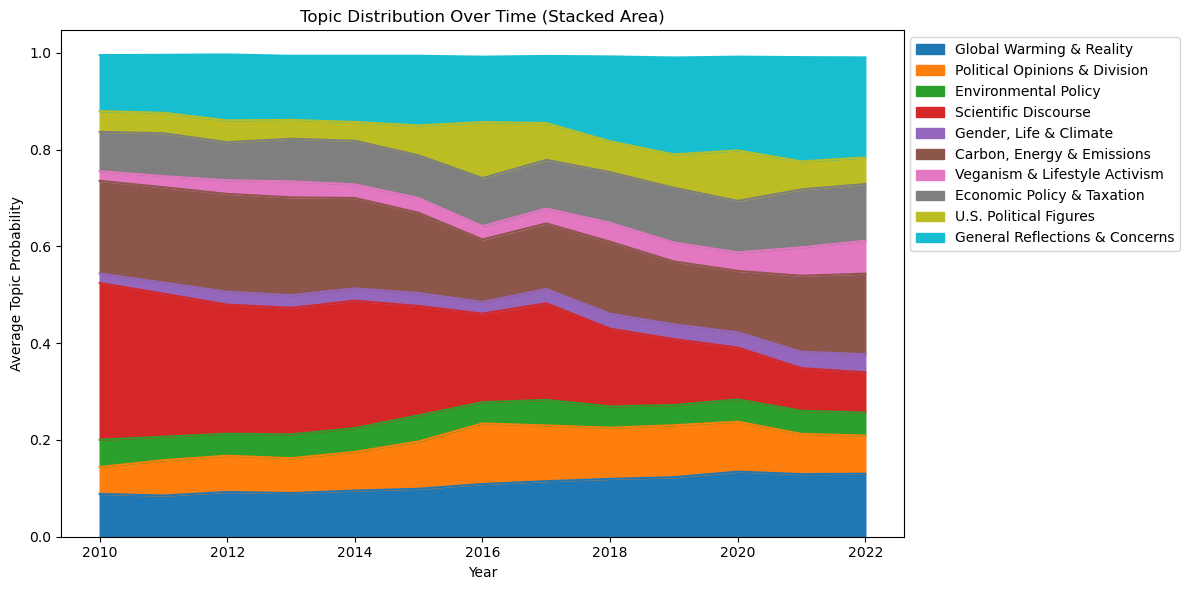

In [14]:
# Convert Spark DataFrame to Pandas
pdf = df_yearly.toPandas()

# Pivot table
pivot_df = pdf.pivot(index="year", columns="topic", values="avg_prob").fillna(0)

# Rename columns using topic labels
pivot_df.columns = [topic_labels.get(t, f"Topic {t}") for t in pivot_df.columns]

# Plot stacked area chart
pivot_df.plot(kind='area', stacked=True, figsize=(12, 6), colormap='tab10')

plt.title("Topic Distribution Over Time (Stacked Area)")
plt.xlabel("Year")
plt.ylabel("Average Topic Probability")
plt.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))  # Move legend outside
plt.tight_layout()
plt.show()

### Stacked Area Summary:

- **Global Warming & Reality** (blue): Gradually increased over the years, showing growing engagement with the fundamental concept of climate change itself.
- **Political Opinions & Division** (orange): Became more prominent after 2016, likely influenced by political events and increased polarization in climate discourse.
- **Environmental Policy** (green): Maintained a relatively small but consistent share, indicating ongoing but limited discussion around regulations and governmental responses.
- **Scientific Discourse** (red): The dominant topic in early years (2010–2015), but declined over time as the discourse shifted away from scientific explanations.
- **Gender, Life & Climate** (purple): Remained a small yet steady theme, highlighting consistent, though niche, attention to human and social dimensions of climate.
- **Carbon, Energy & Emissions** (brown): Consistent across all years, suggesting that discussions around energy sources and carbon impact have remained a central and enduring concern in climate discourse on Reddit.
- **Veganism & Lifestyle Activism** (pink): Showed a slight upward trend, suggesting that lifestyle and dietary choices are increasingly part of the climate conversation.
- **Economic Policy & Taxation** (gray): Fairly stable presence, reflecting sustained but moderate discussion of economic mechanisms like carbon taxes.
- **U.S. Political Figures** (yellow-green): Slight increase in later years, aligning with rising attention to figures like Trump, Biden, or political leadership on climate.
- **General Reflections & Concerns** (cyan): Grew significantly after 2016 and became the most prominent topic in recent years, showing a shift toward personal, emotional, and existential expressions about climate change.

## Identifying and Visualizing Top Topic Per Year
In this section, we rank topics within each year based on their average probability and extract the most dominant topic per year. We then visualize this using a bar chart, where each bar represents the highest-probability topic in a given year. 

In [16]:
# Rank topics by avg_prob within each year
w = Window.partitionBy("year").orderBy(col("avg_prob").desc())

df_top1 = (
    df_yearly
      .withColumn("rank", row_number().over(w))
      .filter(col("rank") == 1)
      .select("year", "topic", "avg_prob")
      .orderBy("year")
)

df_top1_labeled = df_top1.withColumn("topic_label", label_udf(col("topic")))

display(df_top1_labeled)

DataFrame[year: int, topic: int, avg_prob: double, topic_label: string]

In [22]:
df_top1_labeled.show()

25/04/25 14:14:05 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
25/04/25 14:16:30 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
25/04/25 14:16:30 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
25/04/25 14:16:31 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
25/04/25 14:16:31 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
25/04/25 14:20:44 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
25/04/25 14:20:45 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
25/04/25 14:20:45 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
25/04/25 14:20:46 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
25/04/25 14:20:46 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
25/04/25 14:20:47 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


+----+-----+-------------------+--------------------+
|year|topic|           avg_prob|         topic_label|
+----+-----+-------------------+--------------------+
|2010|    3|0.32391085152373106|Scientific Discourse|
|2011|    3|0.29553096728069733|Scientific Discourse|
|2012|    3|0.26667025467199823|Scientific Discourse|
|2013|    3| 0.2615335652515925|Scientific Discourse|
|2014|    3| 0.2631397671574851|Scientific Discourse|
|2015|    3|0.22583721624023922|Scientific Discourse|
|2016|    3| 0.1831171710089514|Scientific Discourse|
|2017|    3|0.19947589163388085|Scientific Discourse|
|2018|    9|0.17547183977220113|General Reflectio...|
|2019|    9|0.20024291458796245|General Reflectio...|
|2020|    9|0.19387323230079834|General Reflectio...|
|2021|    9|0.21541035184005164|General Reflectio...|
|2022|    9|0.20690783150081077|General Reflectio...|
+----+-----+-------------------+--------------------+



25/04/29 11:32:47 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


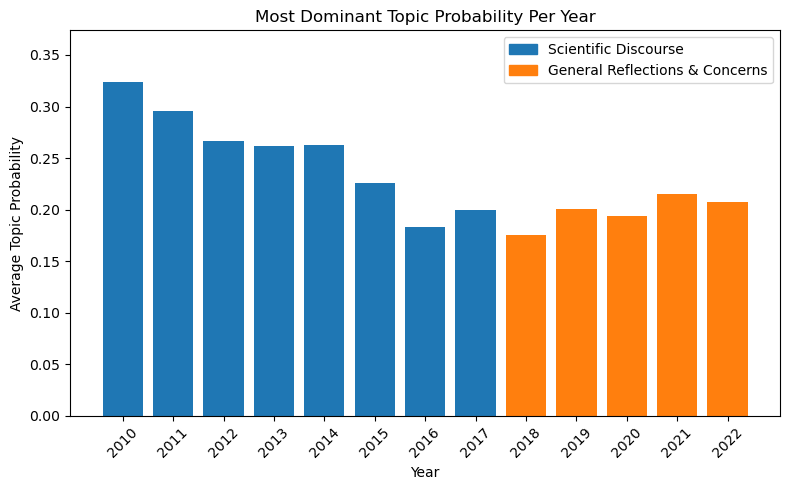

In [31]:
import matplotlib.patches as mpatches

# Convert to Pandas and plot
pdf = df_top1_labeled.toPandas()

# Define colors
colors = ['#1f77b4' if t == 'Scientific Discourse' else '#ff7f0e'
          for t in pdf['topic_label']]

plt.figure(figsize=(8, 5))
bars = plt.bar(pdf['year'].astype(str), pdf['avg_prob'], color=colors)

# Build legend
patch1 = mpatches.Patch(color='#1f77b4', label='Scientific Discourse')
patch2 = mpatches.Patch(color='#ff7f0e', label='General Reflections & Concerns')
plt.legend(handles=[patch1, patch2], loc='upper right')

plt.xticks(rotation=45)
plt.xlabel('Year')
plt.ylabel('Average Topic Probability')
plt.title('Most Dominant Topic Probability Per Year')
plt.ylim(0, pdf['avg_prob'].max() + 0.05)

plt.tight_layout()
plt.show()

#### 2010–2017: Focus on **Scientific Discourse**
- The dominant topic during these years was **Scientific Discourse**.
- Discussions were heavily centered around **climate science, data, evidence, and research**.
- Users were primarily concerned with **proving**, **understanding**, and **debunking denial** of climate change.
- This suggests that during the early 2010s, Reddit users were focused on **raising awareness and building scientific literacy** around climate issues.

#### 2018–2022: Shift to **General Reflections & Concerns**
- From 2018 onward, **General Reflections and Concerns** became the dominant topic.
- Conversations became **more emotional, existential, and social** — focusing on **personal reactions**, **worries about the future**, and **societal implications** of climate change.
- The tone shifted from scientific analysis to **moral reflections**, **frustration**, and **calls for action**.

#### Interpretation:
- This transition mirrors **real-world cultural trends**: as scientific consensus solidified, public discourse shifted toward **how to cope** with climate change rather than **proving it exists**.
- From **scientific evidence** to **emotional engagement**, the thematic shift is clearly visible and strongly matches real-world developments.

## Detecting Topic Spikes and Drops Over Time

Here, we explore how each LDA topic's average probability changes from year to year to identify **sudden shifts in public attention**:

- The topic distributions are first pivoted by year and topic.
- We compute **year-over-year differences** to capture changes in topic prominence.
- The **top 5 spikes** (biggest increases) and **top 5 drops** (biggest decreases) are printed.
- A line chart visualizes changes over time for selected topics, with **black stars** and **X marks** indicating the most dramatic increases and decreases.

This helps us uncover major **events, shifts, or trends** in climate discourse on Reddit.

In [15]:
# Convert to Pandas
pdf = df_yearly.toPandas()

# Pivot to wide format: rows = years, columns = topics
pivot_df = pdf.pivot(index="year", columns="topic", values="avg_prob").fillna(0)

# Compute year-over-year difference
diff_df = pivot_df.diff().dropna() 

# Add topic labels
diff_df.columns = [topic_labels.get(t, f"Topic {t}") for t in diff_df.columns]

# Find spikes or drops
top_spikes = diff_df.stack().sort_values(ascending=False).head(5)
top_drops  = diff_df.stack().sort_values().head(5)

print(" Biggest Spikes:")
print(top_spikes)

print("\n Biggest Drops:")
print(top_drops)

 Biggest Spikes:
year                                
2016  U.S. Political Figures            0.053813
2018  General Reflections & Concerns    0.036773
2020  U.S. Political Figures            0.035286
2021  Carbon, Energy & Emissions        0.030150
2016  Political Opinions & Division     0.027590
dtype: float64

 Biggest Drops:
year                        
2021  U.S. Political Figures   -0.046267
2016  Scientific Discourse     -0.042720
2017  U.S. Political Figures   -0.039714
2018  Scientific Discourse     -0.038818
2015  Scientific Discourse     -0.037303
dtype: float64


25/05/03 15:37:13 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


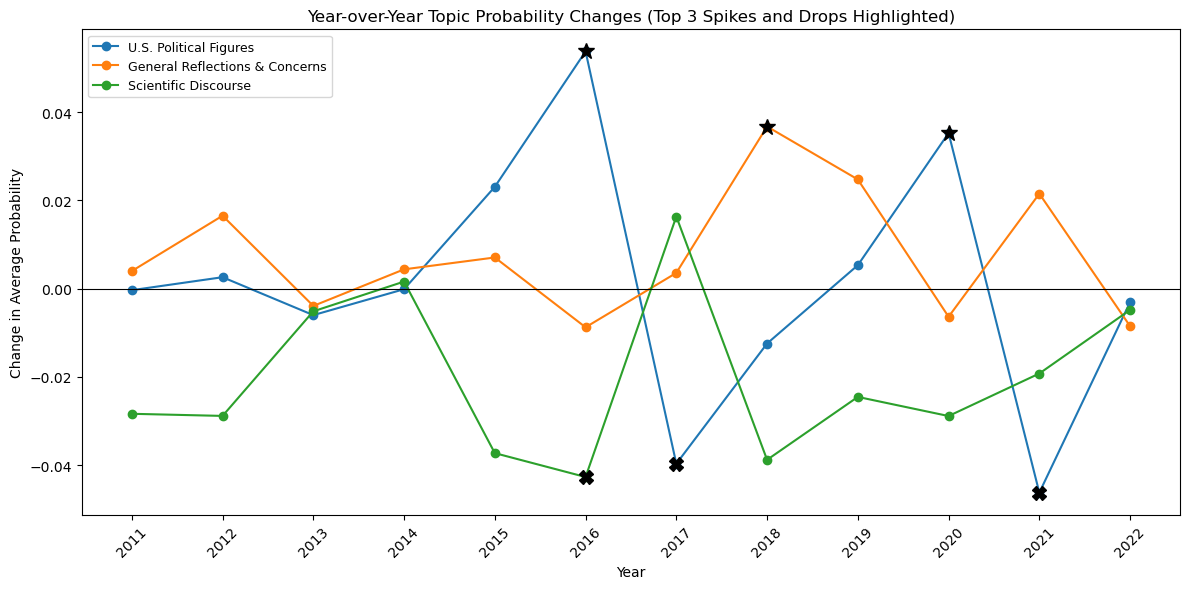

In [23]:
plt.figure(figsize=(12, 6))

selected_topics = [
    'U.S. Political Figures',
    'General Reflections & Concerns',
    'Scientific Discourse',
]

# Plot the normal lines
for topic in selected_topics:
    plt.plot(diff_df.index, diff_df[topic], marker='o', label=topic)

# Find the top 5 spikes and drops
top_3_spikes = diff_df[selected_topics].stack().sort_values(ascending=False).head(3)
top_3_drops  = diff_df[selected_topics].stack().sort_values().head(3)

# Mark the top 5 spikes with black stars
for (year, topic), value in top_5_spikes.items():
    plt.plot(year, value, marker='*', color='black', markersize=12)

# Mark the top 5 drops with black Xs
for (year, topic), value in top_5_drops.items():
    plt.plot(year, value, marker='X', color='black', markersize=10)

plt.title('Year-over-Year Topic Probability Changes (Top 3 Spikes and Drops Highlighted)')
plt.xlabel('Year')
plt.ylabel('Change in Average Probability')
plt.xticks(diff_df.index, rotation=45)
plt.axhline(0, color='black', linewidth=0.8)
plt.legend(loc="upper left", fontsize=9)
plt.tight_layout()
plt.show()


- **Biggest Spikes:**
  - In **2016**, *U.S. Political Figures* surged (+0.0538), likely driven by the U.S. presidential election.
  - In **2018**, *General Reflections & Concerns* sharply increased (+0.0368), suggesting a growing focus on personal and emotional responses to climate change.
  - In **2020**, *U.S. Political Figures* spiked again (+0.0353), corresponding to another intense election year.
  - In **2021**, *Carbon, Energy & Emissions* rose (+0.0302), potentially reflecting increasing interest in energy sources.
  - In **2016**, *Political Opinions & Division* also jumped (+0.0276), indicating rising political polarization.

- **Biggest Drops:**
  - In **2021**, *U.S. Political Figures* dropped significantly (-0.0463) after the 2020 election cycle concluded.
  - In **2016**, *Scientific Discourse* declined sharply (-0.0427), suggesting a shift away from scientific discussions toward more politicized narratives.
  - In **2017**, *U.S. Political Figures* experienced another drop (-0.0397), reflecting reduced attention after election-driven peaks.
  - In **2018**, *Scientific Discourse* continued its downward trend (-0.0388).
  - In **2015**, *Scientific Discourse* had already started declining (-0.0373), hinting at an early transition before political events accelerated the shift.

These sudden changes align well with major global events and reflect how public climate discussions on Reddit evolved over time.

##  Topic Volatility Over Time

In this step, we measure **how much each topic's prevalence fluctuated** across the years:
- We compute the **standard deviation** of average probability for each topic over time — higher values mean more volatility.
- Topics are sorted from most to least volatile.

In [16]:
# Convert to Pandas
pdf = df_yearly.toPandas()

# Pivot to wide format: year × topics
pivot_df = pdf.pivot(index="year", columns="topic", values="avg_prob").fillna(0)

# Calculate standard deviation across years for each topic
topic_volatility = pivot_df.std()

# Replace topic numbers with labels
topic_volatility.index = [topic_labels.get(t, f"Topic {t}") for t in topic_volatility.index]

# Sort from most volatile to least
topic_volatility = topic_volatility.sort_values(ascending=False)

print(topic_volatility)

Scientific Discourse              0.080669
General Reflections & Concerns    0.035320
Carbon, Energy & Emissions        0.029046
U.S. Political Figures            0.024321
Political Opinions & Division     0.020331
Global Warming & Reality          0.017709
Veganism & Lifestyle Activism     0.013699
Economic Policy & Taxation        0.013513
Gender, Life & Climate            0.004820
Environmental Policy              0.004256
dtype: float64


25/05/03 15:37:14 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


- **Scientific Discourse** emerged as the most volatile topic, suggesting that scientific discussions around climate change rose and fell sharply across different periods.
- **General Reflections & Concerns** and **Carbon, Energy & Emissions** showed moderate volatility, reflecting evolving public attention toward emotional responses and energy sources.
- **U.S. Political Figures** and **Political Opinions & Division** also showed some volatility, likely linked to election cycles and political events.
- **Global Warming & Reality** and **Veganism & Lifestyle Activism** were relatively more stable but still showed noticeable fluctuations.
- **Gender, Life & Climate** and **Environmental Policy** were the most stable topics over time, maintaining consistent but lower levels of discussion.

Overall, these findings highlight how certain themes in climate discourse respond dynamically to global events, while others remain relatively steady anchors in the conversation.

## Topic Distributions: Pre-COVID vs Post-COVID

COVID-19 triggered widespread lockdowns, reduced global travel, and brought temporary declines in carbon emissions. It also shifted global priorities, media attention, and public concerns. By comparing climate-related Reddit discussions before and after 2020, we explore how the pandemic may have influenced the way people talk about climate change—whether scientific focus declined, political tensions rose, or personal reflections became more prominent.

25/05/03 15:37:14 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


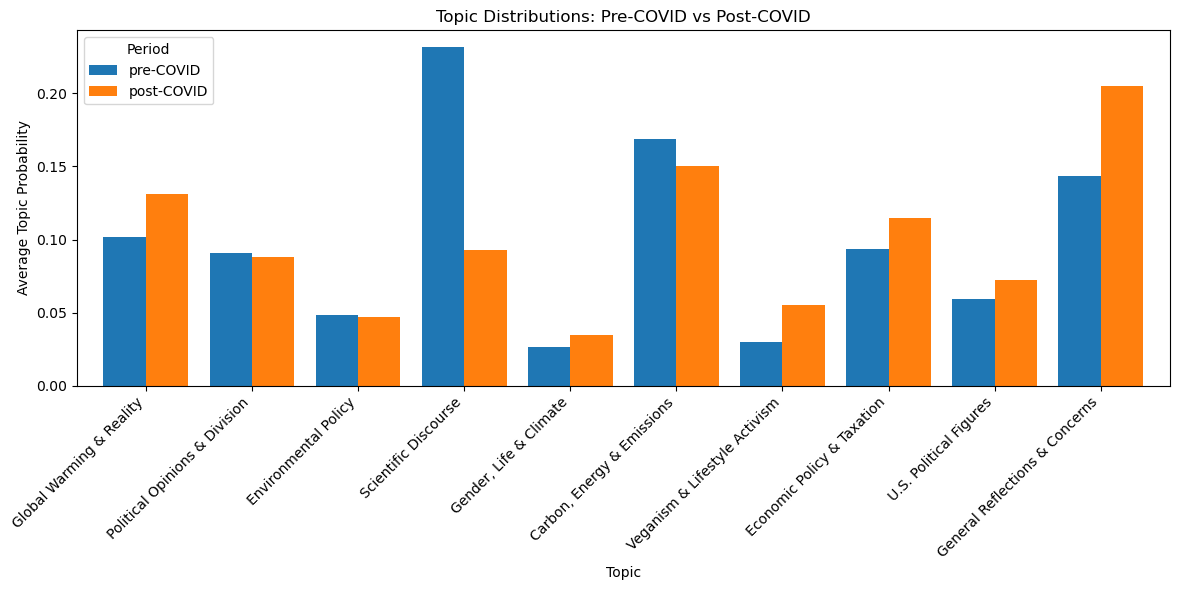

In [17]:
pdf = df_yearly.toPandas()

# Map year to pre/post COVID
pdf['period_covid'] = pdf['year'].apply(lambda y: 'pre-COVID' if y < 2020 else 'post-COVID')

# Pivot to wide format
pivot = pdf.pivot(index='year', columns='topic', values='avg_prob').fillna(0)

# Add period to the pivoted frame
pivot['period_covid'] = pivot.index.map(lambda y: 'pre-COVID' if y < 2020 else 'post-COVID')

# Group by period and average
period_avg = pivot.groupby('period_covid').mean().T  # transpose so topics are rows

# Rename index with topic labels
period_avg.index = [ topic_labels[i] for i in period_avg.index ]

period_avg = period_avg[['pre-COVID', 'post-COVID']]

ax = period_avg.plot(
    kind='bar',
    figsize=(12,6),
    color=['#1f77b4','#ff7f0e'],  
    width=0.8
)
ax.set_ylabel("Average Topic Probability")
ax.set_xlabel("Topic")
ax.set_title("Topic Distributions: Pre-COVID vs Post-COVID")
ax.legend(title="Period", loc='upper left')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Interpretation of COVID-19 Impact on Climate Topics

- **Scientific Discourse** dropped significantly after COVID-19, likely because public attention shifted from climate science to pandemic-related science and health issues.
- **General Reflections & Concerns** rose noticeably, suggesting people became more introspective about societal issues, lifestyles, and the future during lockdowns.
- **Economic Policy & Taxation** increased, possibly reflecting growing concern over economic recovery, government spending, and policy priorities post-pandemic.
- **Veganism & Lifestyle Activism** gained momentum, potentially driven by heightened awareness of health, food systems, and sustainability during the COVID-19 era.
- Overall, the results show a shift from purely scientific climate discussions toward more personal, political, and practical themes after the pandemic started.